## Introduction

## Setup

In [14]:
### load the required packages
import numpy as np 
import scipy as sp 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

In [15]:
### Load the dataset 
df = pd.read_csv('D:/Dataset/Side_project_FED_interest_rates/index.csv', encoding='utf-8')

In [16]:
### Overview of the adtaset 

print('The shape:')
print(df.shape)

print('\nThe information:')
print(df.info())

The shape:
(904, 10)

The information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 10 columns):
Year                            904 non-null int64
Month                           904 non-null int64
Day                             904 non-null int64
Federal Funds Target Rate       462 non-null float64
Federal Funds Upper Target      103 non-null float64
Federal Funds Lower Target      103 non-null float64
Effective Federal Funds Rate    752 non-null float64
Real GDP (Percent Change)       250 non-null float64
Unemployment Rate               752 non-null float64
Inflation Rate                  710 non-null float64
dtypes: float64(7), int64(3)
memory usage: 70.7 KB
None


## EDA

#### Transform the columns Year, Month and Day into one column Date

In [17]:
### combine the date-related columns

from datetime import datetime
df['Date'] = df.ix[:, ['Year', 'Month', 'Day']].apply(lambda x: datetime.strptime(str(x[0])+'/'+str(x[1])+'/'+str(x[2]), '%Y/%m/%d'), axis=1)

print(df['Date'][:5]) # checking

0   1954-07-01
1   1954-08-01
2   1954-09-01
3   1954-10-01
4   1954-11-01
Name: Date, dtype: datetime64[ns]


#### Extract the dates when the Fed changed the interest rate

In [18]:
### When the date doesn't have number in Effective Federal Funds Rate, it is the date the Fed changed the interest rate 

ind = df['Effective Federal Funds Rate'].isnull().values

## However, the 2017/3/1 is an exception. Maybe the date is too current.

### filter out the new dataset consisting of the dates with changes
df_change = df.ix[ind, :]
df_change = df_change.ix[df_change['Date'] != datetime(2017, 3, 1), :]
df_change.index = df_change['Date']
print(df_change.shape)
print(df_change.tail())
print(df_change.info())

### construct the new dataset consisting of the dates without changes 
df_nochange = df.ix[~ind, :]
df_nochange = pd.concat([df_nochange, df.ix[df['Date'] == datetime(2017, 3, 1), :]], axis=0)
df_nochange.index = df_nochange['Date']
print()
print(df_nochange.shape)
print(df_nochange.tail())
print(df_nochange.info())

(151, 11)
            Year  Month  Day  Federal Funds Target Rate  \
Date                                                      
2008-10-29  2008     10   29                        1.0   
2008-12-16  2008     12   16                        NaN   
2015-12-16  2015     12   16                        NaN   
2016-12-14  2016     12   14                        NaN   
2017-03-16  2017      3   16                        NaN   

            Federal Funds Upper Target  Federal Funds Lower Target  \
Date                                                                 
2008-10-29                         NaN                         NaN   
2008-12-16                        0.25                        0.00   
2015-12-16                        0.50                        0.25   
2016-12-14                        0.75                        0.50   
2017-03-16                        1.00                        0.75   

            Effective Federal Funds Rate  Real GDP (Percent Change)  \
Date          

#### Visualize the trends of financial data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 1954-07-01 to 2017-03-01
Data columns (total 12 columns):
Year                            753 non-null int64
Month                           753 non-null int64
Day                             753 non-null int64
Federal Funds Target Rate       315 non-null float64
Federal Funds Upper Target      99 non-null float64
Federal Funds Lower Target      99 non-null float64
Effective Federal Funds Rate    752 non-null float64
Real GDP (Percent Change)       753 non-null float64
Unemployment Rate               752 non-null float64
Inflation Rate                  710 non-null float64
Date                            753 non-null datetime64[ns]
Target Rate                     414 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(3)
memory usage: 76.5 KB
None


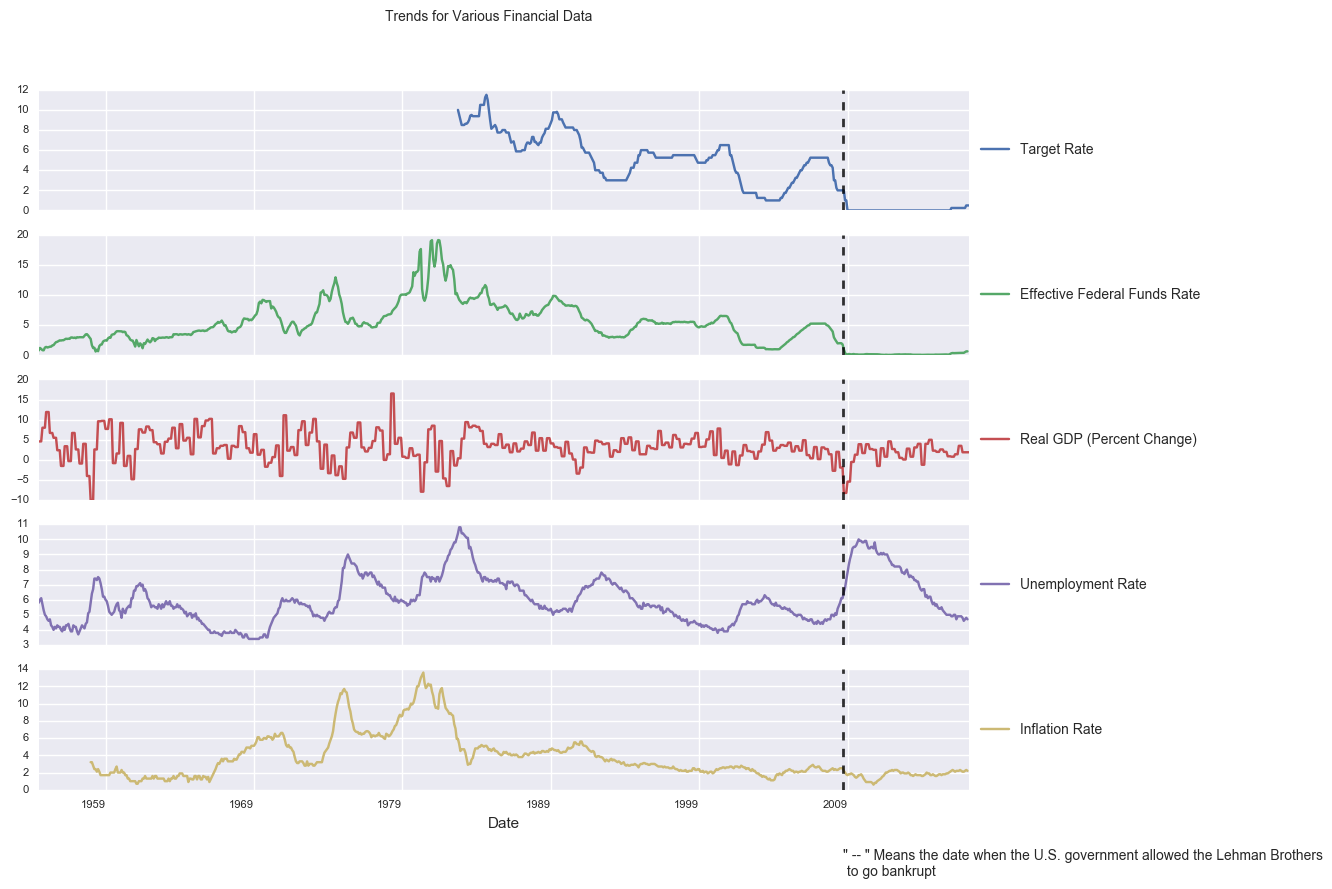

In [19]:
### Construct the target new target rate column
df_nochange['Target Rate'] = list(range(len(df_nochange)))
df_nochange['Target Rate'][df_nochange['Federal Funds Lower Target'].isnull()] = df_nochange['Federal Funds Target Rate'][df_nochange['Federal Funds Lower Target'].isnull()]
df_nochange['Target Rate'][~df_nochange['Federal Funds Lower Target'].isnull()] = df_nochange['Federal Funds Lower Target'][~df_nochange['Federal Funds Lower Target'].isnull()]
df_nochange['Real GDP (Percent Change)'].fillna(method='pad', inplace=True)
print(df_nochange.info()) # for checking 

axes = df_nochange.ix[:, ['Target Rate', 'Effective Federal Funds Rate', 'Real GDP (Percent Change)', 'Unemployment Rate', 'Inflation Rate']].plot(subplots=True,
    figsize=(12, 10), fontsize=8, title='Trends for Various Financial Data', rot=0)

for ax in axes:
    ax.axvline(x=datetime(2008, 9, 15), color='k', linestyle='--', linewidth=2, alpha=0.8)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.text(datetime(2008, 9, 15), -10, '" -- " Means the date when the U.S. government allowed the Lehman Brothers\n to go bankrupt', fontsize=10)

# reference: https://www.theguardian.com/business/2011/aug/07/global-financial-crisis-key-stages

#### Visualize the relationships between various financial data

In [20]:
### check for the first time for valid target rate
print(df_nochange['Date'][~df_nochange['Target Rate'].isnull()][:5]) # since 1982/10/1

Date
1982-10-01   1982-10-01
1982-11-01   1982-11-01
1982-12-01   1982-12-01
1983-01-01   1983-01-01
1983-02-01   1983-02-01
Name: Date, dtype: datetime64[ns]


In [21]:
### Extract the data since 1983
cor_tab = df_nochange.ix[df_nochange['Date'] >= datetime(1983, 1, 1), ['Target Rate', 'Effective Federal Funds Rate', 'Real GDP (Percent Change)', 'Unemployment Rate', 'Inflation Rate']]
print(np.sum(cor_tab.isnull())) # for checking 
print(cor_tab.ix[datetime(2017, 3, 1), :])

# Since the 2017/3/1 has NAs on multiple data, we remove this row here
cor_tab = cor_tab.ix[:datetime(2017, 2, 1), :]
print()
print(np.sum(cor_tab.isnull())) # for checking
print(cor_tab.head())

Target Rate                     0
Effective Federal Funds Rate    1
Real GDP (Percent Change)       0
Unemployment Rate               1
Inflation Rate                  1
dtype: int64
Target Rate                     0.5
Effective Federal Funds Rate    NaN
Real GDP (Percent Change)       1.9
Unemployment Rate               NaN
Inflation Rate                  NaN
Name: 2017-03-01 00:00:00, dtype: float64

Target Rate                     0
Effective Federal Funds Rate    0
Real GDP (Percent Change)       0
Unemployment Rate               0
Inflation Rate                  0
dtype: int64
            Target Rate  Effective Federal Funds Rate  \
Date                                                    
1983-01-01        8.500                          8.68   
1983-02-01        8.500                          8.51   
1983-03-01        8.500                          8.77   
1983-04-01        8.625                          8.80   
1983-05-01        8.625                          8.63   

           

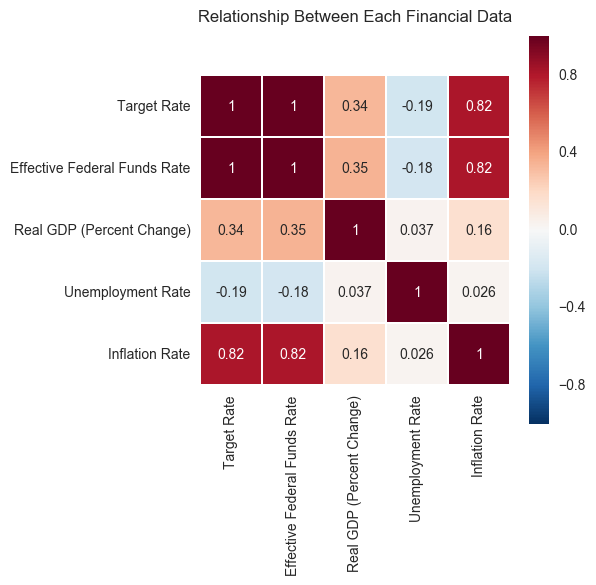

In [22]:
### Visualize the data
plt.figure(figsize=[5, 5])
sns.heatmap(cor_tab.corr(), linewidths=1, annot=True, square=True)
plt.title('Relationship Between Each Financial Data', y=1.15)

In [23]:
### Move the data for GDP, Unemployment and Inflation forward for 1 period to see check the relationship between financial data 
### and interest rates
cor_tab.ix[:, ['Real GDP (Percent Change)', 'Unemployment Rate', 'Inflation Rate']] = \
    cor_tab.ix[:, ['Real GDP (Percent Change)', 'Unemployment Rate', 'Inflation Rate']].shift(1)

print(cor_tab.head())

            Target Rate  Effective Federal Funds Rate  \
Date                                                    
1983-01-01        8.500                          8.68   
1983-02-01        8.500                          8.51   
1983-03-01        8.500                          8.77   
1983-04-01        8.625                          8.80   
1983-05-01        8.625                          8.63   

            Real GDP (Percent Change)  Unemployment Rate  Inflation Rate  
Date                                                                      
1983-01-01                        NaN                NaN             NaN  
1983-02-01                        5.3               10.4             4.7  
1983-03-01                        5.3               10.4             4.7  
1983-04-01                        5.3               10.3             4.7  
1983-05-01                        9.4               10.2             4.3  


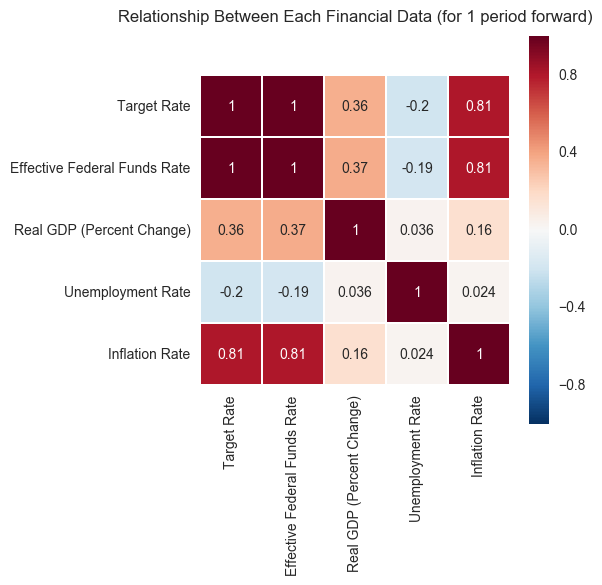

In [24]:
### Visualize the data
plt.figure(figsize=[5, 5])
sns.heatmap(cor_tab.corr(), linewidths=1, annot=True, square=True)
plt.title('Relationship Between Each Financial Data (for 1 period forward)', y=1.15)

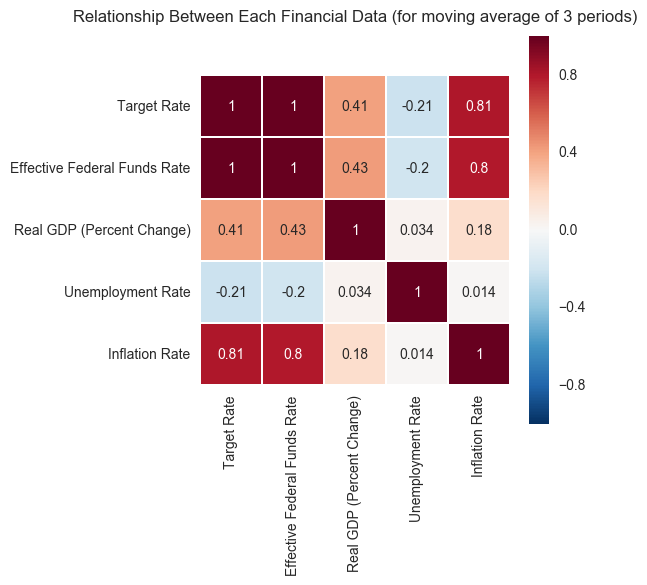

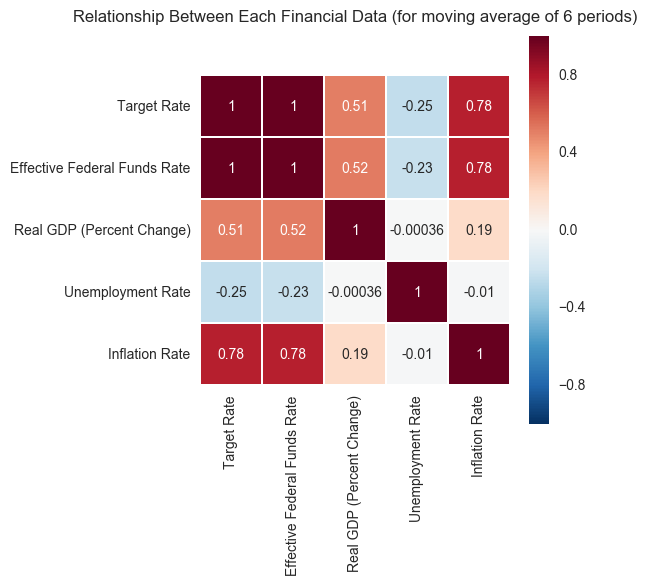

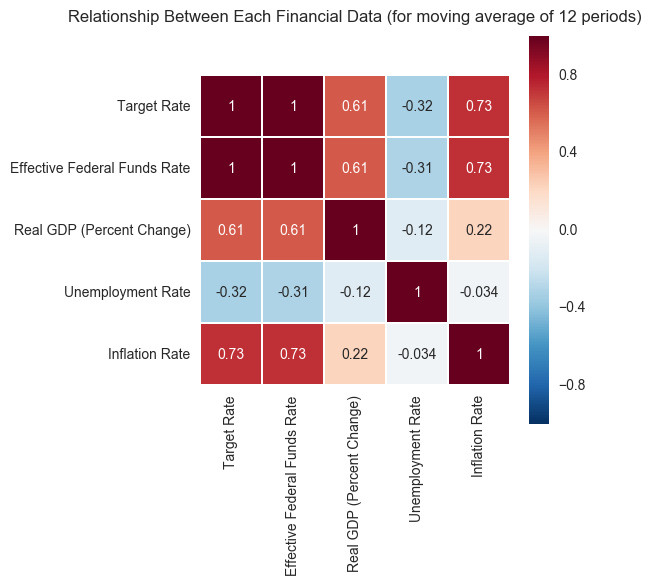

In [25]:
### Calculate the moviing average for the data of GDP, Unemployment and Inflation forward for 3, 6, 12 periods and then check the
### relationships between interest rates and them 

rolling_periods = [3, 6, 12]

cor_tab = df_nochange.ix[df_nochange['Date'] >= datetime(1983, 1, 1), ['Target Rate', 'Effective Federal Funds Rate', 'Real GDP (Percent Change)', 'Unemployment Rate', 'Inflation Rate']]
cor_tab = cor_tab.ix[:datetime(2017, 2, 1), :]

for period in rolling_periods:
    cor_tab_rolling = cor_tab.copy(deep=True)
    
    cor_tab.ix[:, ['Real GDP (Percent Change)', 'Unemployment Rate', 'Inflation Rate']] = \
    cor_tab.ix[:, ['Real GDP (Percent Change)', 'Unemployment Rate', 'Inflation Rate']].rolling(window=period).mean().shift(1)
    
    plt.figure(figsize=[5, 5])
    sns.heatmap(cor_tab.corr(), linewidths=1, annot=True, square=True)
    plt.title('Relationship Between Each Financial Data (for moving average of %s periods)' %(str(period)), y=1.15)